# 1. Imports

In [1]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline  
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from xgboost import XGBClassifier
import math
import joblib
import random

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
import time


# 2. Data Visualisation, Preprocessing, and Feature Engineering

In [2]:
# Get the parent directory (DS3000-Group-4) and navigate to Data
current_dir = os.getcwd()
data_path = os.path.join(os.path.dirname(current_dir), 'Data', 'mxmh_survey_results.csv')

df = pd.read_csv(data_path) # Load the dataset
df = df.drop(columns=['Exploratory', 'Timestamp', 
                      'Primary streaming service', 'BPM', 'Music effects', 'Permissions']) # Drop unnecessary columns
df = df.dropna() # Drop rows with any missing values
df.head() # Display the first few rows of the cleaned dataset

,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD
0,18.0,3.0,Yes,Yes,Yes,Latin,Yes,Rarely,Never,Rarely,...,Never,Very frequently,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0
1,63.0,1.5,Yes,No,No,Rock,No,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0
2,18.0,4.0,No,No,No,Video game music,Yes,Never,Never,Very frequently,...,Sometimes,Rarely,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0
3,61.0,2.5,Yes,No,Yes,Jazz,Yes,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0
4,18.0,4.0,Yes,No,No,R&B,No,Never,Never,Rarely,...,Never,Sometimes,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0


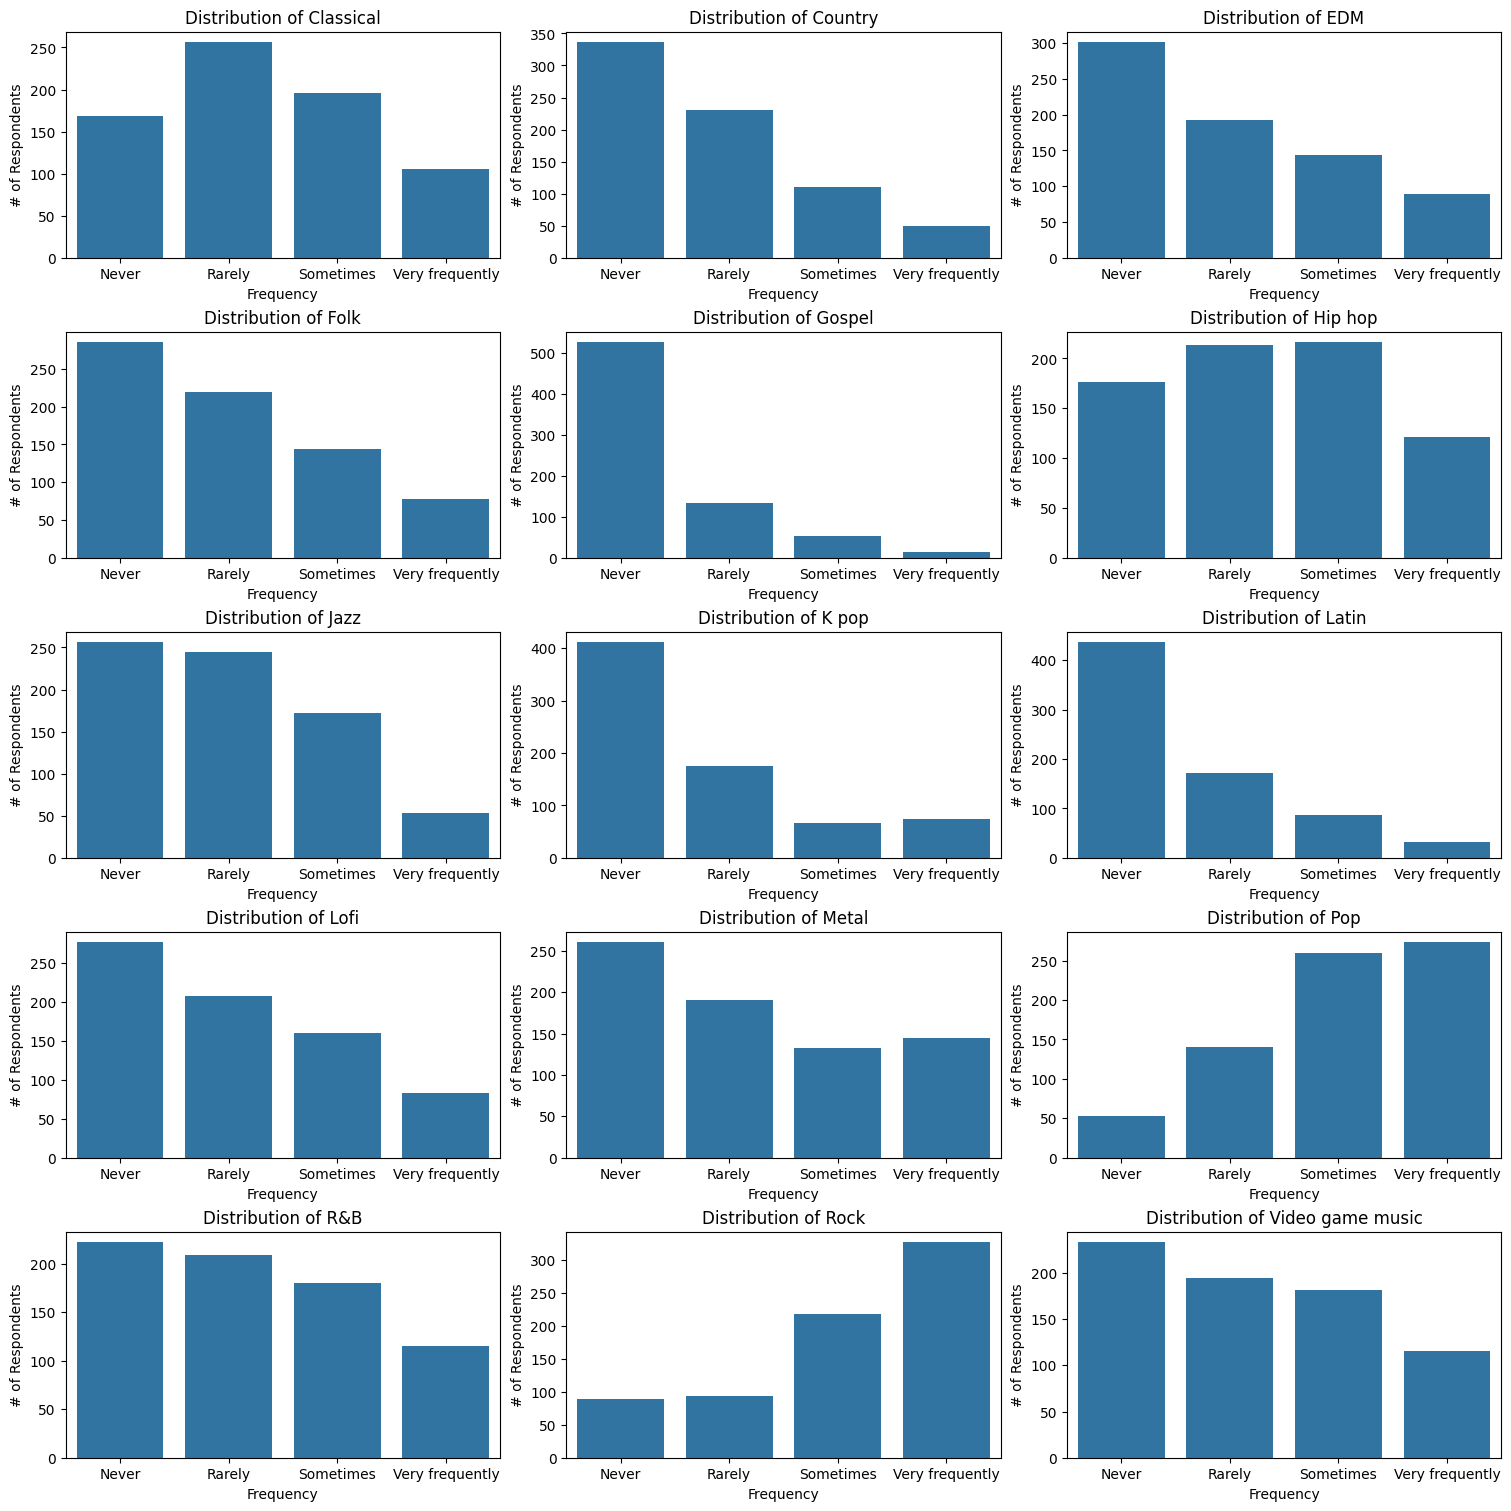

In [3]:
# Plot the distribution of each genre frequency in a grid
genre = ['Classical', 'Country', 'EDM', 'Folk', 'Gospel', 'Hip hop', 'Jazz', 'K pop',
                 'Latin', 'Lofi', 'Metal', 'Pop', 'R&B', 'Rock', 'Video game music']

# Resolve actual dataframe column names (handles either "Genre" or "Frequency [Genre]" style)
mh_col_names = []
for g in genre:
    candidate = f'Frequency [{g}]'
    if candidate in df.columns:
        mh_col_names.append(candidate)
    elif g in df.columns:
        mh_col_names.append(g)
    else:
        print(f"Warning: column for genre '{g}' not found in df")

if not mh_col_names:
    raise RuntimeError("No genre columns found to plot")

# Frequency order
freq_order = ['Never', 'Rarely', 'Sometimes', 'Very frequently']

# Layout: choose number of columns and compute rows
n = len(mh_col_names)
ncols = 3                  # change to 4 or 2 as you prefer
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3), constrained_layout=True)

# Flatten axes for easy iteration
if isinstance(axes, np.ndarray):
    axes_list = axes.flatten()
else:
    axes_list = [axes]

# Plot into each axis
for ax, col in zip(axes_list, mh_col_names):
    s = df[col].dropna()
    # Ensure categorical with explicit order
    s = pd.Categorical(s, categories=freq_order, ordered=True)
    sns.countplot(x=s, ax=ax, color='C0', order=freq_order)
    # nicer title (strip 'Frequency []' wrapper if present)
    title = col.replace('Frequency [', '').replace(']', '')
    ax.set_title(f'Distribution of {title}')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('# of Respondents')

# Hide any unused axes
for ax in axes_list[len(mh_col_names):]:
    ax.set_visible(False)

plt.show()

In [4]:
# Drop gospel and latin, as we do not have enough data points on those who listen to it sometimes or very frequently
df = df.drop(columns=['Frequency [Gospel]', 'Frequency [Latin]'])

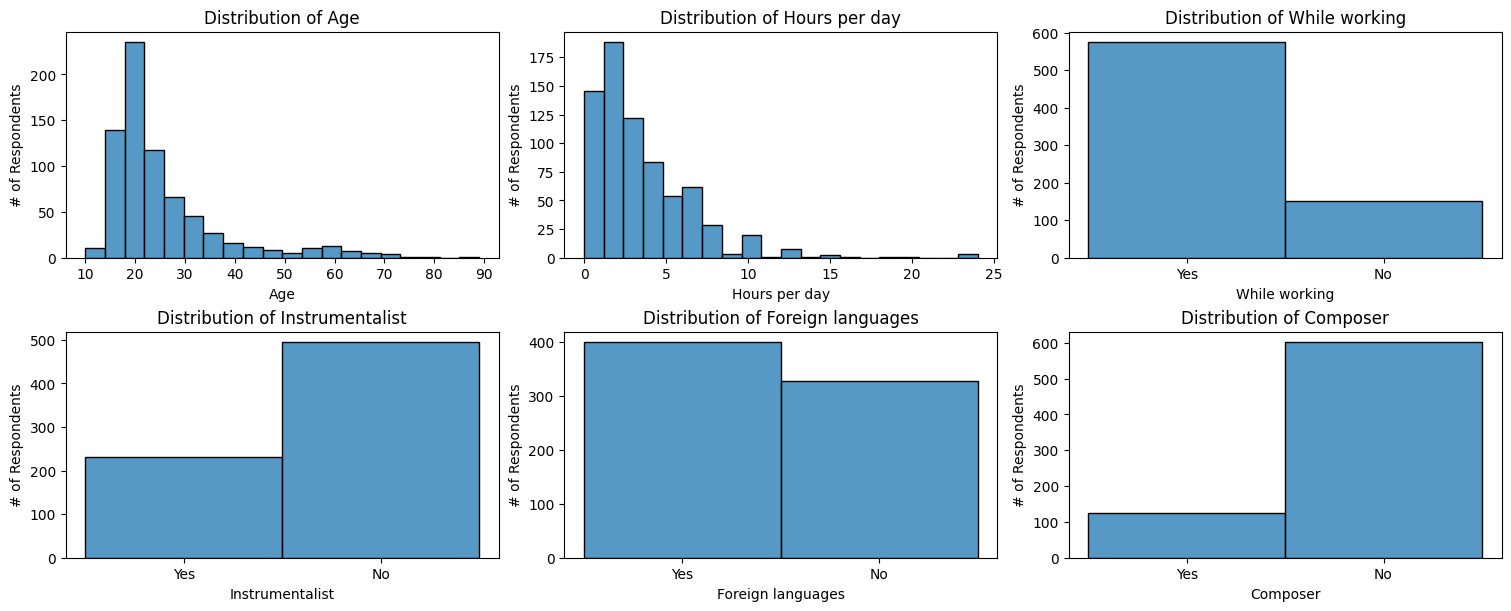

In [5]:
# Plot the distribution of Non-Genre Features
mh_condition = ['Age', 'Hours per day', 'While working', 'Instrumentalist', 'Foreign languages', 'Composer' ]

# Resolve actual dataframe column names (handles either "Genre" or "Frequency [Genre]" style)
mh_col_names = []
for g in mh_condition:
    candidate = f'[{g}]'
    if candidate in df.columns:
        mh_col_names.append(candidate)
    elif g in df.columns:
        mh_col_names.append(g)
    else:
        print(f"Warning: column for feature '{g}' not found in df")

if not mh_col_names:
    raise RuntimeError("No feature columns found to plot")

# Layout: choose number of columns and compute rows
n = len(mh_col_names)
ncols = 3                  # change to 4 or 2 as you prefer
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3), constrained_layout=True)

# Flatten axes for easy iteration
if isinstance(axes, np.ndarray):
    axes_list = axes.flatten()
else:
    axes_list = [axes]

# Plot into each axis
for ax, col in zip(axes_list, mh_col_names):
    sns.histplot(df[col].dropna(), bins=20, kde=False, ax=ax, color='C0')
    # nicer title (strip 'Frequency []' wrapper if present)
    title = col.replace('Frequency [', '').replace(']', '')
    ax.set_title(f'Distribution of {title}')
    ax.set_xlabel(col)
    ax.set_ylabel('# of Respondents')

# Hide any unused axes
for ax in axes_list[len(mh_col_names):]:
    ax.set_visible(False)

plt.show()    

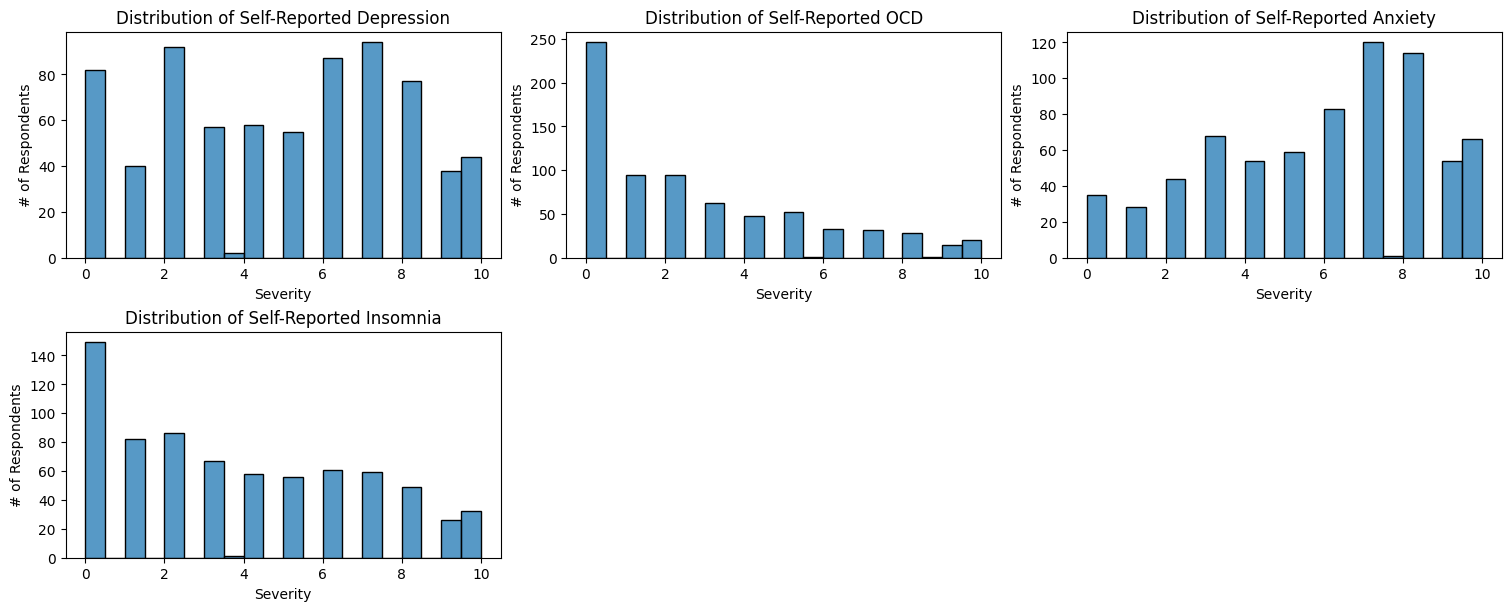

In [6]:
# Plot the distribution of each genre frequency in a grid
mh_condition = ['Depression', 'OCD', 'Anxiety', 'Insomnia' ]

# Resolve actual dataframe column names (handles either "Genre" or "Frequency [Genre]" style)
mh_col_names = []
for g in mh_condition:
    candidate = f'[{g}]'
    if candidate in df.columns:
        mh_col_names.append(candidate)
    elif g in df.columns:
        mh_col_names.append(g)
    else:
        print(f"Warning: column for genre '{g}' not found in df")

if not mh_col_names:
    raise RuntimeError("No MH columns found to plot")

# Layout: choose number of columns and compute rows
n = len(mh_col_names)
ncols = 3                  # change to 4 or 2 as you prefer
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3), constrained_layout=True)

# Flatten axes for easy iteration
if isinstance(axes, np.ndarray):
    axes_list = axes.flatten()
else:
    axes_list = [axes]

# Plot into each axis
for ax, col in zip(axes_list, mh_col_names):
    sns.histplot(df[col].dropna(), bins=20, kde=False, ax=ax, color='C0')
    # nicer title (strip 'Frequency []' wrapper if present)
    title = col.replace('Severity [', '').replace(']', '')
    ax.set_title(f'Distribution of Self-Reported {title}')
    ax.set_xlabel('Severity')
    ax.set_ylabel('# of Respondents')

# Hide any unused axes
for ax in axes_list[len(mh_col_names):]:
    ax.set_visible(False)

plt.show()

We see that we do not have many respondants reporting symptoms of OCD. Therefore, we may not be able to accurately model music-factor trends relating to higher/lower levels of OCD.

We notice that most respondants experience moderate to high anxiety.

We notice that we have good balance of respondants experiencing various levels of depression. We may have more success forecasting this.

In [7]:
# Display summary statistics of the dataset
df.describe()

,Age,Hours per day,Anxiety,Depression,Insomnia,OCD
count,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000
mean,25.241047,3.564807,5.832645,4.803030,3.712810,2.629477
std,12.081723,3.006324,2.791839,3.027309,3.082849,2.845403
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,2.000000,4.000000,2.000000,1.000000,0.000000
50%,21.000000,3.000000,6.000000,5.000000,3.000000,2.000000
75%,28.000000,5.000000,8.000000,7.000000,6.000000,4.000000
max,89.000000,24.000000,10.000000,10.000000,10.000000,10.000000


In [8]:
# Frame mental health condition columns as classification targets
mh_condition = ['Depression', 'OCD', 'Anxiety', 'Insomnia' ]

def to_3class(score_series):
    """
    Map numeric scores to 3 classes:
    0–3  -> 0 (Low)
    4–6  -> 1 (Moderate)
    7–10 -> 2 (High)
    """
    bins = [-np.inf, 3.0, 6.0, np.inf] # Define class bin edges
    labels = [0, 1, 2] # Corresponding class labels
    return pd.cut(score_series, bins=bins, labels=labels).astype(int) # Convert to int type


# Convert target columns if they exist
target_conditions = ['Anxiety', 'Depression', 'Insomnia', 'OCD']
for t in target_conditions:
    if t in df.columns:
        df[f"{t}_class"] = to_3class(df[t])

# Drop original target columns if they exist
existing_targets = [t for t in target_conditions if t in df.columns]
if existing_targets:
    df = df.drop(columns=existing_targets)    

df.head()


,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety_class,Depression_class,Insomnia_class,OCD_class
0,18.0,3.0,Yes,Yes,Yes,Latin,Yes,Rarely,Never,Rarely,...,Never,Very frequently,Sometimes,Very frequently,Never,Sometimes,0,0,0,0
1,63.0,1.5,Yes,No,No,Rock,No,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Rarely,Very frequently,Rarely,2,0,0,0
2,18.0,4.0,No,No,No,Video game music,Yes,Never,Never,Very frequently,...,Sometimes,Rarely,Never,Rarely,Rarely,Very frequently,2,2,2,0
3,61.0,2.5,Yes,No,Yes,Jazz,Yes,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Never,Never,Never,2,2,0,0
4,18.0,4.0,Yes,No,No,R&B,No,Never,Never,Rarely,...,Never,Sometimes,Very frequently,Very frequently,Never,Rarely,2,0,1,2


In [9]:
# Convert favourite genre into a boost applied to the users favourite genre frequency

# Define frequency mapping
freq_map = {
    "Never": 0,
    "Rarely": 1,
    "Sometimes": 2,
    "Frequently": 3,
    "Very frequently": 4
}

# Copy df to avoid mutating original
df_fe = df.copy()

# Identify genre frequency columns
freq_cols = [col for col in df.columns if col.startswith("Frequency")]


# Convert frequency columns to numeric using the mapping
for col in freq_cols:
    df_fe[col] = df_fe[col].map(freq_map).astype(float)


# Create a normalised genre name lookup so "Fav genre" matches frequency column names
# Example: "Rock" → "Frequency [Rock]"
def genre_to_freq_column(genre):
    return f"Frequency [{genre}]"

fav_genre_boost = 1.0   # Boost amount 1.0 to add to favourite genre frequency

# Convert favourite genre into frequency column name
def convert_fav_genre_to_freq_col(genre):
    return f"Frequency [{genre}]"

# Apply boost to favourite genre frequency
for idx, row in df_fe.iterrows():
    fav = row["Fav genre"]
    target_col = convert_fav_genre_to_freq_col(fav)

    if target_col in freq_cols:
        df_fe.loc[idx, target_col] = df_fe.loc[idx, target_col] + fav_genre_boost

# Drop original Fav genre column 
df_fe = df_fe.drop(columns=["Fav genre"])

# Display the processed dataframe
df_fe.head()


,Age,Hours per day,While working,Instrumentalist,Composer,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety_class,Depression_class,Insomnia_class,OCD_class
0,18.0,3.0,Yes,Yes,Yes,Yes,1.0,0.0,1.0,0.0,...,0.0,4.0,2.0,4.0,0.0,2.0,0,0,0,0
1,63.0,1.5,Yes,No,No,No,2.0,0.0,0.0,1.0,...,0.0,2.0,2.0,1.0,5.0,1.0,2,0,0,0
2,18.0,4.0,No,No,No,Yes,0.0,0.0,4.0,0.0,...,2.0,1.0,0.0,1.0,1.0,5.0,2,2,2,0
3,61.0,2.5,Yes,No,Yes,Yes,2.0,0.0,0.0,1.0,...,0.0,2.0,2.0,0.0,0.0,0.0,2,2,0,0
4,18.0,4.0,Yes,No,No,No,0.0,0.0,1.0,0.0,...,0.0,2.0,5.0,4.0,0.0,1.0,2,0,1,2


In [10]:
# Start from a clean copy of the original dataframe
df_fe1 = df_fe.copy()

# Clean col names to avoid key errors
df_fe1.columns = (
    df_fe1.columns.astype(str)
    .str.strip()
    .str.replace('\xa0', '', regex=False)
    .str.replace(r'\s+', ' ', regex=True)
)

print("Cleaned column names:", df_fe1.columns.tolist())

# Define age group bins and labels
age_bins = [0, 17, 25, 35, 45, 55, 65, np.inf]
age_labels = ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']

if 'Age' not in df_fe1.columns:
    raise KeyError("'Age' column not found in dataframe.")

# Create Age Group categorical feature
df_fe1['Age Group'] = pd.cut(
    df_fe1['Age'], bins=age_bins, labels=age_labels
)

# One-hot encode Age Group (categorical, not ordinal!)
df_fe1 = pd.get_dummies(df_fe1, columns=['Age Group'], prefix='AgeGroup')

# Drop the original Age column if not needed
df_fe1 = df_fe1.drop(columns=['Age'])

# Identify Yes/No columns
yes_no_cols = []
for col in df_fe1.columns:
    nonnull = df_fe1[col].dropna().unique()
    if len(nonnull) > 0 and set(nonnull).issubset({'Yes', 'No'}):
        yes_no_cols.append(col)
    if len(nonnull) > 0 and set(nonnull).issubset({'True', 'False'}):
        yes_no_cols.append(col)

print("Detected Yes/No columns:", yes_no_cols)

# Convert boolean to binary 1/0
for col in yes_no_cols:
    df_fe1[col] = df_fe1[col].map({'Yes': 1, 'No': 0, 'True': 1, 'False': 0})

# Conver true false to binary 1/0
for col in df_fe1.columns:
    if df_fe1[col].dtype == bool:
        df_fe1[col] = df_fe1[col].astype(int)

df_fe1.head(10) # Display the first 10 rows of the final feature-engineered dataframe

# Save the final preprocessed dataframe to a new CSV file
processed_data_path = os.path.join(os.path.dirname(current_dir), 'Data', 'mxmh_survey_results_processed.csv')
df_fe1.to_csv(processed_data_path, index=False)

# Print message to confirm saving
print(f"Processed data saved to {processed_data_path}")


Cleaned column names: ['Age', 'Hours per day', 'While working', 'Instrumentalist', 'Composer', 'Foreign languages', 'Frequency [Classical]', 'Frequency [Country]', 'Frequency [EDM]', 'Frequency [Folk]', 'Frequency [Hip hop]', 'Frequency [Jazz]', 'Frequency [K pop]', 'Frequency [Lofi]', 'Frequency [Metal]', 'Frequency [Pop]', 'Frequency [R&B]', 'Frequency [Rap]', 'Frequency [Rock]', 'Frequency [Video game music]', 'Anxiety_class', 'Depression_class', 'Insomnia_class', 'OCD_class']
Detected Yes/No columns: ['While working', 'Instrumentalist', 'Composer', 'Foreign languages']
Processed data saved to c:\Users\Isabella\Documents\School\Third_Year\DS_3000_Machine_learning\DS3000-Group-4\Data\mxmh_survey_results_processed.csv


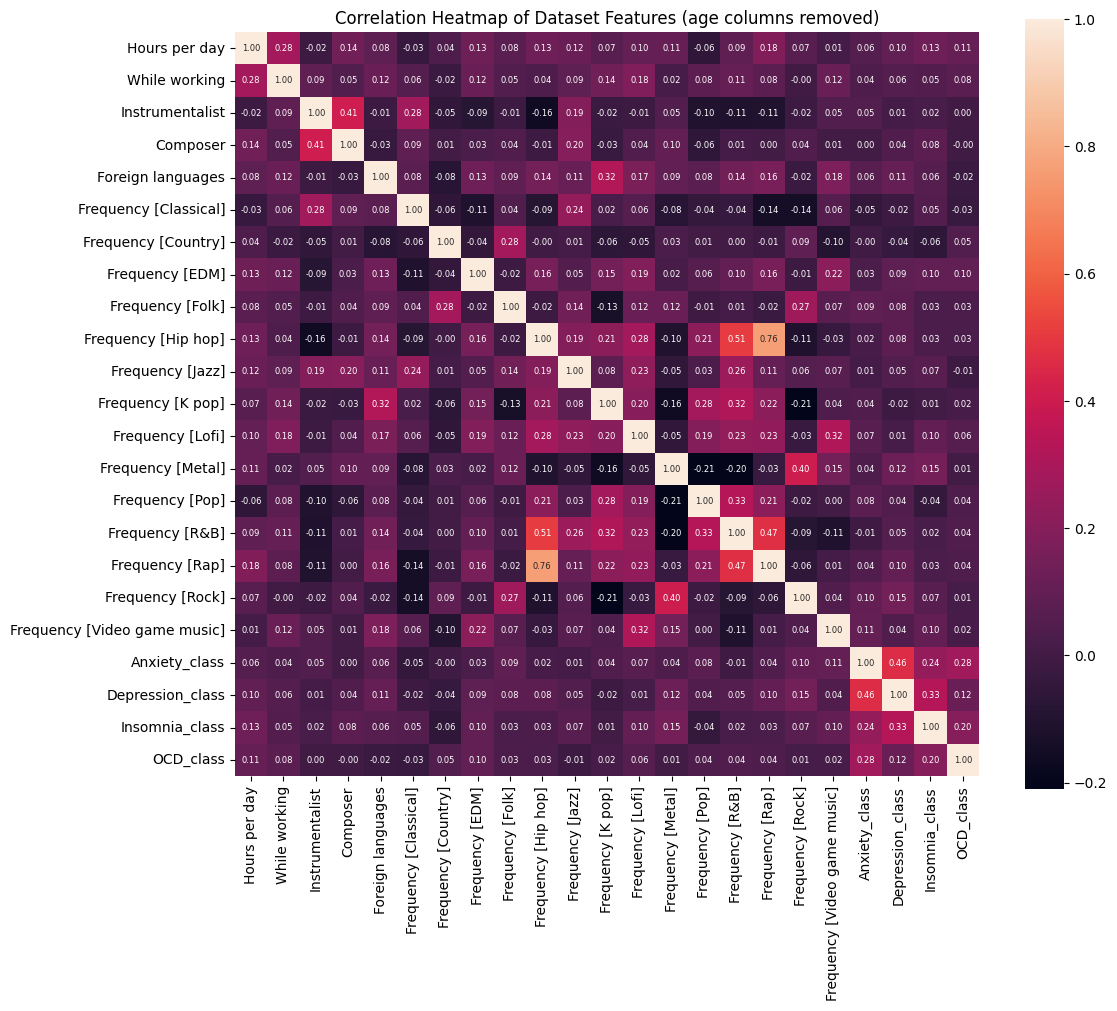

In [11]:
# Create a correlation heatmap for the dataset

# Drop any one-hot encoded AgeGroup columns so the matrix excludes age bins
age_cols = [c for c in df_fe1.columns if str(c).startswith('AgeGroup')]
if age_cols:
    corr_df = df_fe1.drop(columns=age_cols)
else:
    corr_df = df_fe1

corr = corr_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size': 6}, square=True)
plt.title("Correlation Heatmap of Dataset Features (age columns removed)")
plt.show()

No individual correlations between genres and conditions can be observed here. However, we do notice a positive correlation between those who listen to Rap and Hip Hop, as well as Hip Hop and R&B.

Below we will conduct 3 experiments to investigate the correlation between music listening preferences/habits and mental health condition severity.

# XGBoost Experiment

[I 2025-12-01 22:37:31,918] A new study created in memory with name: no-name-14337300-36c6-4fb2-9d3b-ebfc881c0243
[I 2025-12-01 22:37:32,198] Trial 0 finished with value: 0.3884588850229837 and parameters: {'n_estimators': 236, 'learning_rate': 0.14924665633879416, 'max_depth': 6, 'subsample': 0.7967516986791005, 'colsample_bytree': 0.8028645041567553, 'gamma': 0.5285406582907832, 'min_child_weight': 2}. Best is trial 0 with value: 0.3884588850229837.
[I 2025-12-01 22:37:32,316] Trial 1 finished with value: 0.2804238521719404 and parameters: {'n_estimators': 117, 'learning_rate': 0.028530419140995217, 'max_depth': 3, 'subsample': 0.8566327392961184, 'colsample_bytree': 0.7471121938035117, 'gamma': 1.1864399230247693, 'min_child_weight': 7}. Best is trial 0 with value: 0.3884588850229837.
[I 2025-12-01 22:37:32,499] Trial 2 finished with value: 0.3736086629805448 and parameters: {'n_estimators': 313, 'learning_rate': 0.23330790808344248, 'max_depth': 8, 'subsample': 0.8410368452386584, 

Best hyperparameters: {'n_estimators': 118, 'learning_rate': 0.21139354717859754, 'max_depth': 6, 'subsample': 0.7675424899415978, 'colsample_bytree': 0.8223587271990415, 'gamma': 0.03376721598736454, 'min_child_weight': 9}

Evaluation on test set:
Accuracy: 0.4726027397260274
Precision: 0.4291943521594684
Recall: 0.4158953722334004
F1 Score: 0.4167249179356123
ROC AUC: 0.5593256102995673

Classification report:
              precision    recall  f1-score   support

           0       0.31      0.29      0.30        35
           1       0.43      0.30      0.35        40
           2       0.55      0.66      0.60        71

    accuracy                           0.47       146
   macro avg       0.43      0.42      0.42       146
weighted avg       0.46      0.47      0.46       146



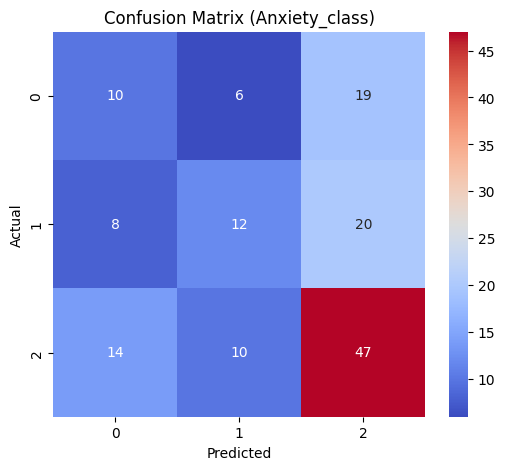

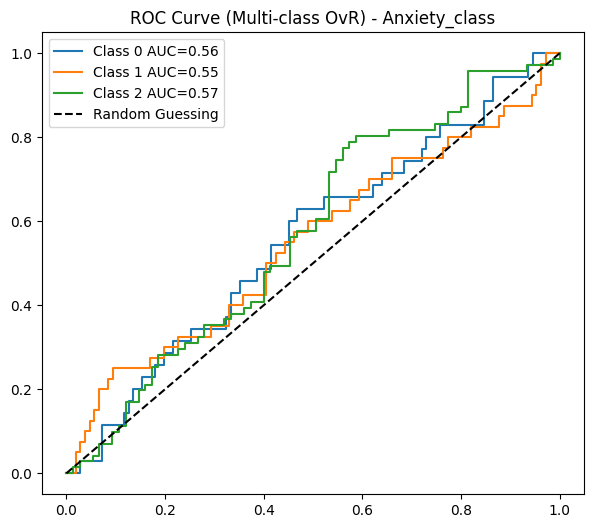

[I 2025-12-01 22:37:37,224] A new study created in memory with name: no-name-ad41f369-3f59-43ec-97f8-7e688994dff1
[I 2025-12-01 22:37:37,412] Trial 0 finished with value: 0.38933222038481974 and parameters: {'n_estimators': 213, 'learning_rate': 0.11628654006163434, 'max_depth': 3, 'subsample': 0.9265838127438171, 'colsample_bytree': 0.6271191568630428, 'gamma': 0.0199138288472287, 'min_child_weight': 7}. Best is trial 0 with value: 0.38933222038481974.


Saved model to: c:\Users\Isabella\Documents\School\Third_Year\DS_3000_Machine_learning\DS3000-Group-4\models\xgboost_anxiety_model.pkl


[I 2025-12-01 22:37:37,635] Trial 1 finished with value: 0.3564668953883696 and parameters: {'n_estimators': 203, 'learning_rate': 0.05640198476880859, 'max_depth': 5, 'subsample': 0.822745230084325, 'colsample_bytree': 0.6785890255632047, 'gamma': 0.15784120457381468, 'min_child_weight': 5}. Best is trial 0 with value: 0.38933222038481974.
[I 2025-12-01 22:37:37,865] Trial 2 finished with value: 0.39438349649817983 and parameters: {'n_estimators': 389, 'learning_rate': 0.0774631782570543, 'max_depth': 5, 'subsample': 0.8864268521699623, 'colsample_bytree': 0.8155892874167657, 'gamma': 0.8862454823356998, 'min_child_weight': 5}. Best is trial 2 with value: 0.39438349649817983.
[I 2025-12-01 22:37:38,037] Trial 3 finished with value: 0.3965604483232535 and parameters: {'n_estimators': 278, 'learning_rate': 0.19370863927310575, 'max_depth': 5, 'subsample': 0.8036698298383507, 'colsample_bytree': 0.6735992206411576, 'gamma': 0.724592406674313, 'min_child_weight': 3}. Best is trial 3 with 

Best hyperparameters: {'n_estimators': 146, 'learning_rate': 0.0605933911276734, 'max_depth': 8, 'subsample': 0.8289054688013291, 'colsample_bytree': 0.8303610734754808, 'gamma': 0.6690279067209973, 'min_child_weight': 2}

Evaluation on test set:
Accuracy: 0.4315068493150685
Precision: 0.40625300625300625
Recall: 0.41507696122712856
F1 Score: 0.4059067359930208
ROC AUC: 0.6074727310713892

Classification report:
              precision    recall  f1-score   support

           0       0.47      0.48      0.48        54
           1       0.29      0.20      0.23        41
           2       0.46      0.57      0.51        51

    accuracy                           0.43       146
   macro avg       0.41      0.42      0.41       146
weighted avg       0.42      0.43      0.42       146



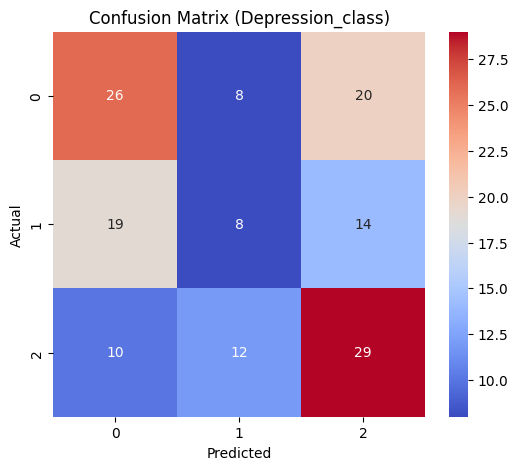

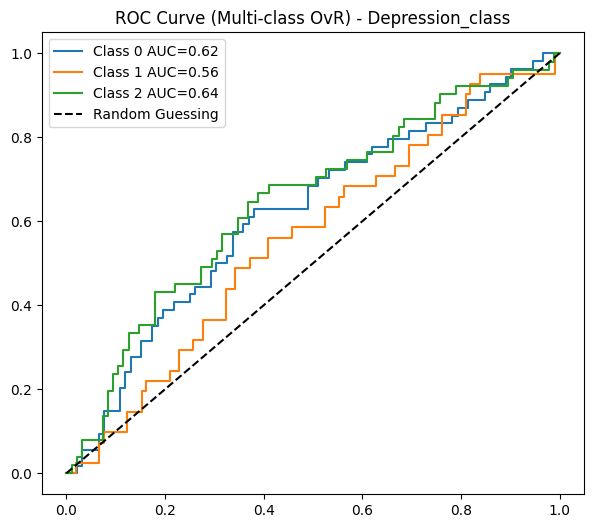

[I 2025-12-01 22:37:48,515] A new study created in memory with name: no-name-fadb58fa-6846-43ac-b369-3410cb5df292
[I 2025-12-01 22:37:48,682] Trial 0 finished with value: 0.380942877245495 and parameters: {'n_estimators': 207, 'learning_rate': 0.22536918025933703, 'max_depth': 7, 'subsample': 0.7158949055641858, 'colsample_bytree': 0.7254036201104166, 'gamma': 1.850356005430379, 'min_child_weight': 4}. Best is trial 0 with value: 0.380942877245495.


Saved model to: c:\Users\Isabella\Documents\School\Third_Year\DS_3000_Machine_learning\DS3000-Group-4\models\xgboost_depression_model.pkl


[I 2025-12-01 22:37:48,928] Trial 1 finished with value: 0.3662467813476383 and parameters: {'n_estimators': 365, 'learning_rate': 0.07112912781881667, 'max_depth': 4, 'subsample': 0.8747271650462327, 'colsample_bytree': 0.8796625224386525, 'gamma': 1.045976603202183, 'min_child_weight': 3}. Best is trial 0 with value: 0.380942877245495.
[I 2025-12-01 22:37:49,167] Trial 2 finished with value: 0.3667728452559229 and parameters: {'n_estimators': 279, 'learning_rate': 0.05420926961093591, 'max_depth': 6, 'subsample': 0.9495162168465441, 'colsample_bytree': 0.7341001220322723, 'gamma': 0.6132573662263656, 'min_child_weight': 7}. Best is trial 0 with value: 0.380942877245495.
[I 2025-12-01 22:37:49,267] Trial 3 finished with value: 0.31966206297825933 and parameters: {'n_estimators': 100, 'learning_rate': 0.18399354298303794, 'max_depth': 7, 'subsample': 0.8613721013501195, 'colsample_bytree': 0.9780555645709157, 'gamma': 1.7124546556932512, 'min_child_weight': 10}. Best is trial 0 with va

Best hyperparameters: {'n_estimators': 343, 'learning_rate': 0.06778308963950963, 'max_depth': 7, 'subsample': 0.9822004532966437, 'colsample_bytree': 0.8699425096202287, 'gamma': 0.20411206114733205, 'min_child_weight': 9}

Evaluation on test set:
Accuracy: 0.4726027397260274
Precision: 0.3456977804803892
Recall: 0.3481240981240981
F1 Score: 0.32614864127469173
ROC AUC: 0.5130285892694512

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.78      0.64        77
           1       0.23      0.08      0.12        36
           2       0.26      0.18      0.21        33

    accuracy                           0.47       146
   macro avg       0.35      0.35      0.33       146
weighted avg       0.40      0.47      0.42       146



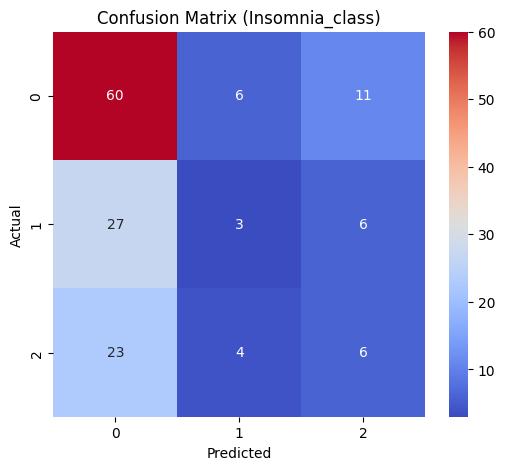

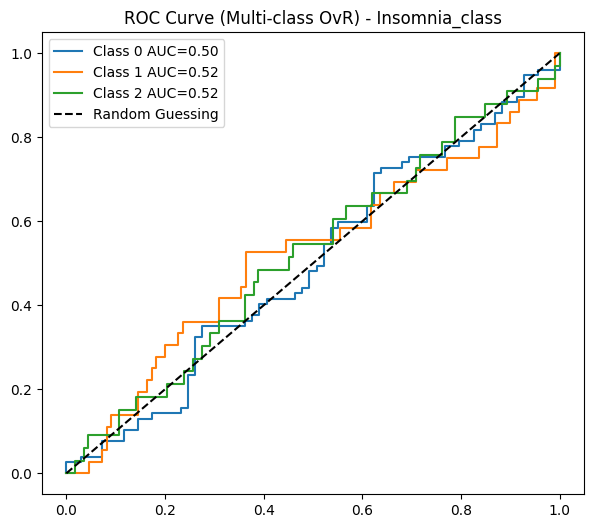

[I 2025-12-01 22:37:56,603] A new study created in memory with name: no-name-7dcbf934-c825-41bf-853c-e58b1bb3b9ab
[I 2025-12-01 22:37:56,799] Trial 0 finished with value: 0.3094027692459784 and parameters: {'n_estimators': 198, 'learning_rate': 0.16859632715219416, 'max_depth': 7, 'subsample': 0.7758421246976768, 'colsample_bytree': 0.8477955360783079, 'gamma': 0.513661824862919, 'min_child_weight': 10}. Best is trial 0 with value: 0.3094027692459784.


Saved model to: c:\Users\Isabella\Documents\School\Third_Year\DS_3000_Machine_learning\DS3000-Group-4\models\xgboost_insomnia_model.pkl


[I 2025-12-01 22:37:57,006] Trial 1 finished with value: 0.2710449025987783 and parameters: {'n_estimators': 278, 'learning_rate': 0.02362104437285334, 'max_depth': 8, 'subsample': 0.7836559887919389, 'colsample_bytree': 0.6378267690599632, 'gamma': 1.7939743919611073, 'min_child_weight': 6}. Best is trial 0 with value: 0.3094027692459784.
[I 2025-12-01 22:37:57,271] Trial 2 finished with value: 0.30266911681170466 and parameters: {'n_estimators': 399, 'learning_rate': 0.1844926472444872, 'max_depth': 4, 'subsample': 0.7104449628036633, 'colsample_bytree': 0.7987162953986473, 'gamma': 1.0188150648604246, 'min_child_weight': 3}. Best is trial 0 with value: 0.3094027692459784.
[I 2025-12-01 22:37:57,477] Trial 3 finished with value: 0.28059197803325736 and parameters: {'n_estimators': 307, 'learning_rate': 0.21819322454669293, 'max_depth': 6, 'subsample': 0.873415304921499, 'colsample_bytree': 0.7178026558921405, 'gamma': 1.6819072528397772, 'min_child_weight': 9}. Best is trial 0 with v

Best hyperparameters: {'n_estimators': 147, 'learning_rate': 0.24689035220018749, 'max_depth': 4, 'subsample': 0.9136157370065491, 'colsample_bytree': 0.8230084756306315, 'gamma': 0.005700397281602429, 'min_child_weight': 9}

Evaluation on test set:
Accuracy: 0.636986301369863
Precision: 0.3021978021978022
Recall: 0.337037037037037
F1 Score: 0.3096500530222694
ROC AUC: 0.4926631560788827

Classification report:
              precision    recall  f1-score   support

           0       0.69      0.90      0.78       100
           1       0.21      0.11      0.15        27
           2       0.00      0.00      0.00        19

    accuracy                           0.64       146
   macro avg       0.30      0.34      0.31       146
weighted avg       0.51      0.64      0.56       146



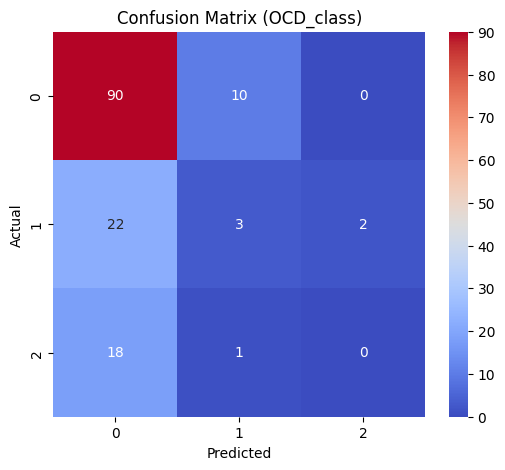

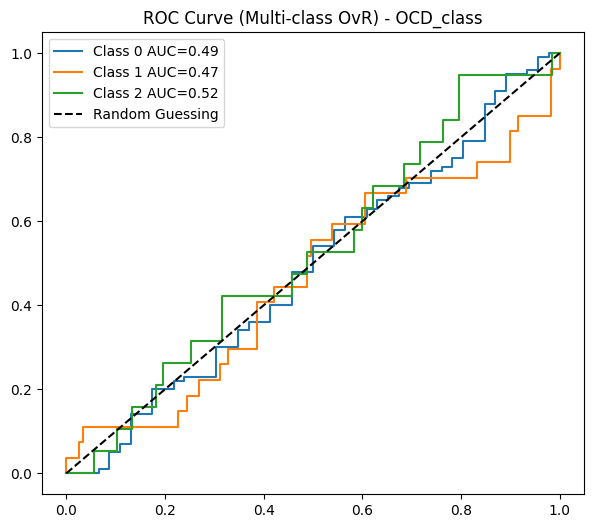

Saved model to: c:\Users\Isabella\Documents\School\Third_Year\DS_3000_Machine_learning\DS3000-Group-4\models\xgboost_ocd_model.pkl


In [12]:
# Reusable training + optuna hyperparameter tuning function for any target (e.g., Anxiety_class, Depression_class, Insomnia_class, OCD_class)
# Optuna is a hyperparameter optimisation framework

# Define function to train, tune, evaluate, and save model
def train_and_eval(target_col, n_trials=50, random_state=42):
    
    # Prepare data based on target column
    if target_col not in df_fe1.columns:
        raise KeyError(f"Target column '{target_col}' not found in dataframe.")

    # Exclude other target columns
    exclude_cols = [c for c in df_fe1.columns if c.endswith('_class')]

    # Prepare features and target
    X = df_fe1.copy().drop(columns=exclude_cols)
    y = df_fe1[target_col].copy()

    # Split data into 80% train and 20% test, stratified by target
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    # Preprocessor (numeric features pipeline)
    num_features = X_train.columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("impute", SimpleImputer(strategy="median")), # Impute missing values with median
                ("scale", StandardScaler()) # Scale numeric features
            ]), num_features) # All features are numeric
        ]
    )

    # Optuna objective function, which trains and evaluates model with given hyperparameters
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 400),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.25),
            "max_depth": trial.suggest_int("max_depth", 3, 8),
            "subsample": trial.suggest_float("subsample", 0.7, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "objective": "multi:softprob",
            "eval_metric": "mlogloss",
            "tree_method": "hist",
            "random_state": random_state,
            "n_jobs": 1
        }

        # Create XGBoost model with trial params
        model = XGBClassifier(**params) 

        # Build pipeline
        pipe = Pipeline([("prep", preprocessor), ("model", model)])

        # Cross-validation
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
        scores = [] # Collect F1 scores across folds

        # Perform cross-validation
        for train_idx, val_idx in cv.split(X_train, y_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            pipe.fit(X_tr, y_tr)
            preds = pipe.predict(X_val)
            score = f1_score(y_val, preds, average="macro")
            scores.append(score)
        return np.mean(scores) # Return average F1 score across folds

    # Create and optimise study to maximise F1 score by tuning hyperparameters
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    # Print best performing hyperparameters
    print("Best hyperparameters:", study.best_params)

    # Train final model with best params on full training set
    best_params = study.best_params
    final_model = XGBClassifier(**best_params, objective="multi:softprob", eval_metric="mlogloss", tree_method="hist", random_state=random_state, n_jobs=-1)
    final_pipe = Pipeline([("prep", preprocessor), ("model", final_model)])
    final_pipe.fit(X_train, y_train)

    # Evaluate on test set
    preds = final_pipe.predict(X_test)
    proba = final_pipe.predict_proba(X_test)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds, average="macro")
    recall = recall_score(y_test, preds, average="macro")
    f1 = f1_score(y_test, preds, average="macro")
    try:
        roc_auc = roc_auc_score(label_binarize(y_test, classes=np.unique(y_train)), proba, average="macro", multi_class="ovr")
    except Exception:
        roc_auc = None

    # Print evaluation results
    print("\nEvaluation on test set:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    if roc_auc is not None:
        print("ROC AUC:", roc_auc)
    print("\nClassification report:")
    print(classification_report(y_test, preds))

    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix ({target_col})")
    plt.show()

    # Plot ROC curves if available
    if roc_auc is not None:
        plt.figure(figsize=(7,6))
        y_bin = label_binarize(y_test, classes=np.unique(y_train))
        for i in range(proba.shape[1]):
            fpr, tpr, _ = roc_curve(y_bin[:, i], proba[:, i])
            plt.plot(fpr, tpr, label=f"Class {i} AUC={auc(fpr,tpr):.2f}")
        plt.plot([0,1], [0,1], 'k--', label='Random Guessing')
        plt.legend()
        plt.title(f"ROC Curve (Multi-class OvR) - {target_col}")
        plt.show()

    # Save model
    safe_name = target_col.replace('_class','').lower()
    model_path = os.path.join(os.path.dirname(current_dir), 'models', f'xgboost_{safe_name}_model.pkl')
    joblib.dump(final_pipe, model_path)
    print("Saved model to:", model_path)

    return {"target": target_col, "accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "roc_auc": roc_auc, "model_path": model_path}

# Run for both Anxiety and Depression (if available)
results = {}
for target in ['Anxiety_class', 'Depression_class', 'Insomnia_class', 'OCD_class']:
    if target in df_fe1.columns:
        results[target] = train_and_eval(target, n_trials=30)
    else:
        print(f"Skipping {target}: column not present")


# MLP Experiment



Training Times:
  MLP: 1693.01 ms

MLP Training Losses per epoch: [1.3306201696395874, 1.098893642425537, 1.0783015489578247, 1.0746421813964844, 1.0715579986572266, 1.0637059211730957, 1.0004096031188965, 1.0524667501449585, 1.0064433813095093, 1.0474985837936401]
MLP Validation Losses per epoch: [1.1473803520202637, 1.186453104019165, 1.13285493850708, 1.1202510595321655, 1.157752275466919, 1.1208184957504272, 1.1655993461608887, 1.1177889108657837, 1.3328697681427002, 1.1413739919662476]
--- MLP Anxiety_class---
Test accuracy: 0.363013698630137
Precision: 0.4180930330843508
Recall: 0.363013698630137
F1 Score: 0.36351377406376384
Confusion Matrix:
 [[11 14  9]
 [ 6 20 11]
 [16 37 22]]
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.32      0.33        34
           1       0.28      0.54      0.37        37
           2       0.52      0.29      0.38        75

    accuracy                           0.36       146
   macro

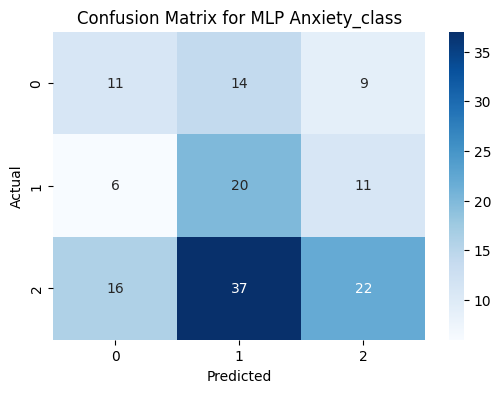

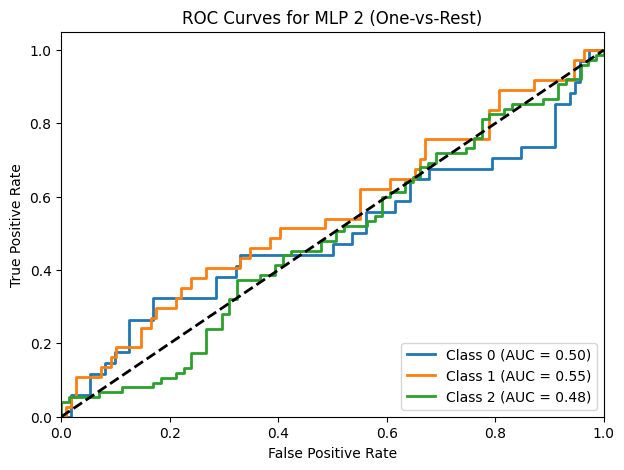


Test Times:
  MLP: 119.43 ms
Training Times:
  MLP: 1355.84 ms

MLP Training Losses per epoch: [1.3902360200881958, 1.1671664714813232, 1.097991943359375, 1.1275959014892578, 1.0908375978469849, 1.1215895414352417, 1.0647337436676025, 1.0699903964996338, 1.0291959047317505, 1.0974130630493164]
MLP Validation Losses per epoch: [1.087408185005188, 1.080889344215393, 1.06715726852417, 1.1371904611587524, 1.0733076333999634, 1.1958221197128296, 1.1158918142318726, 1.0409693717956543, 1.1047512292861938, 1.0716850757598877]
--- MLP Depression_class---
Test accuracy: 0.3219178082191781
Precision: 0.5901988318071137
Recall: 0.3219178082191781
F1 Score: 0.2177471501101638
Confusion Matrix:
 [[40  5  0]
 [44  6  0]
 [47  3  1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.89      0.45        45
           1       0.43      0.12      0.19        50
           2       1.00      0.02      0.04        51

    accuracy                

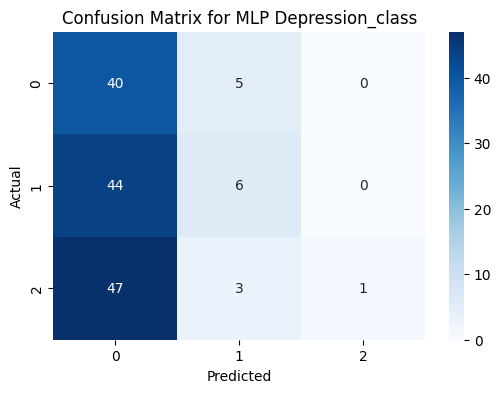

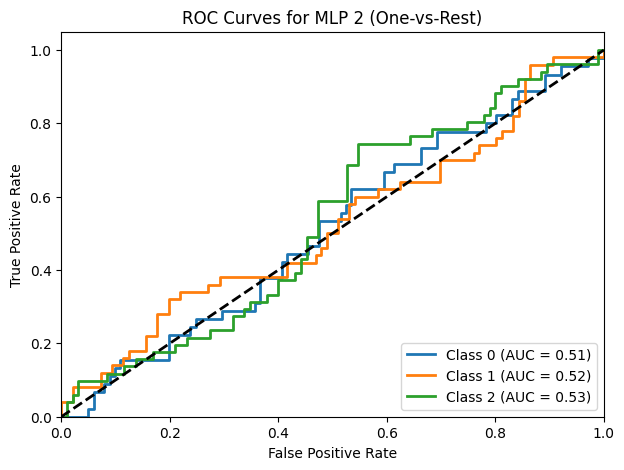


Test Times:
  MLP: 103.51 ms
Training Times:
  MLP: 1402.79 ms

MLP Training Losses per epoch: [1.3636802434921265, 1.095463514328003, 1.0249844789505005, 1.1389985084533691, 1.0869965553283691, 0.9989092946052551, 1.018601417541504, 0.9783158302307129, 1.0590170621871948, 1.0176633596420288]
MLP Validation Losses per epoch: [1.0952649116516113, 1.0689836740493774, 1.06027352809906, 1.0819379091262817, 1.148781180381775, 1.176964521408081, 1.0812453031539917, 1.0620269775390625, 1.2224557399749756, 1.0786776542663574]
--- MLP Insomnia_class---
Test accuracy: 0.4931506849315068
Precision: 0.30664637239979703
Recall: 0.4931506849315068
F1 Score: 0.36949915436395364
Confusion Matrix:
 [[71  2  6]
 [36  0  2]
 [28  0  1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.90      0.66        79
           1       0.00      0.00      0.00        38
           2       0.11      0.03      0.05        29

    accuracy                 

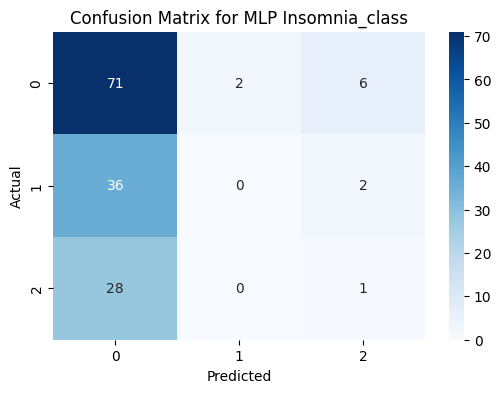

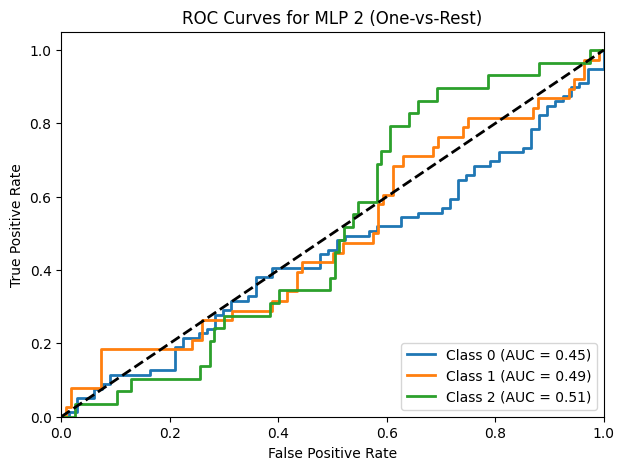


Test Times:
  MLP: 110.14 ms
Training Times:
  MLP: 1370.00 ms

MLP Training Losses per epoch: [1.0713375806808472, 0.8713459968566895, 0.8266009092330933, 0.8760960698127747, 0.8372449278831482, 0.8782302737236023, 0.8607382774353027, 0.7995404005050659, 0.7967340350151062, 0.7845776677131653]
MLP Validation Losses per epoch: [0.8067013621330261, 0.8429731726646423, 0.7758315205574036, 0.7924308776855469, 0.7742880582809448, 0.7897016406059265, 0.7813951373100281, 0.7834751605987549, 0.7836761474609375, 1.0526432991027832]
--- MLP OCD_class---
Test accuracy: 0.3493150684931507
Precision: 0.42121385083713847
Recall: 0.3493150684931507
F1 Score: 0.34592977483860804
Confusion Matrix:
 [[35 56  0]
 [10 16  0]
 [11 18  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.38      0.48        91
           1       0.18      0.62      0.28        26
           2       0.00      0.00      0.00        29

    accuracy                

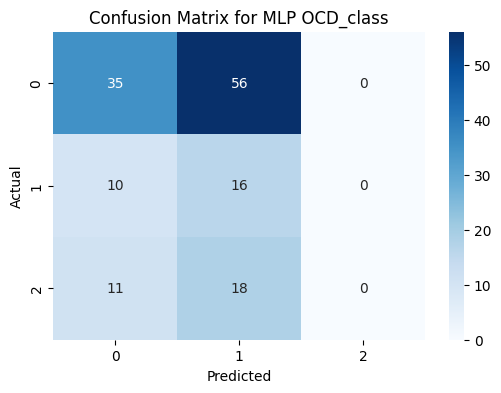

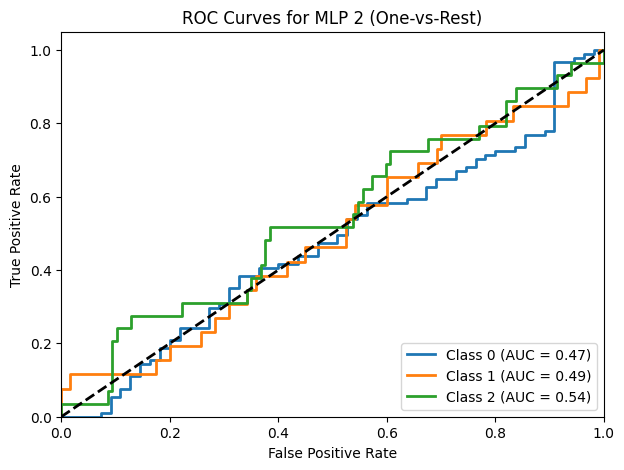


Test Times:
  MLP: 104.06 ms


In [13]:
# Looping the training for the model for each mental health class
classes = ['Anxiety_class', 'Depression_class', 'Insomnia_class', 'OCD_class']
for i in classes:
    X = df_fe1.drop(['Anxiety_class', 'Depression_class', 'Insomnia_class', 'OCD_class'], axis = 1)
    y = df_fe1[i]

    # Split the data into train, validation and test and hold out 20% and 10% of observations as the validation and test set, respectively. Pass random_state=42.
    #First split 70% into train and then another 30% into temp
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    #Split the 30% into 20% for validation and 10% for testing
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

    training_times = {}
    mlp_train_losses = []
    mlp_val_losses = []

    #MLP
    mlp = Sequential()
    mlp.add(Dense(50, input_shape=(X_train.shape[1],), activation='tanh'))
    mlp.add(Dense(100, activation='tanh'))
    mlp.add(Dense(11, activation='softmax'))

    mlp.compile(
        optimizer=SGD(learning_rate=0.1),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    start_time = time.time()
    history_mlp = mlp.fit(
        X_train,
        y_train,
        epochs=10,
        validation_data=(X_val, y_val),
        verbose=0
    )

    end_time = time.time()
    training_times['MLP'] = (end_time - start_time) * 1000 # in milliseconds


    #Report the training time in milli second for all models.
    print("Training Times:")
    for model, t_time in training_times.items():
        print(f"  {model}: {t_time:.2f} ms")

    # These lists will be used in subsequent steps for plotting learning curves
    print("\nMLP Training Losses per epoch:", history_mlp.history['loss'])
    print("MLP Validation Losses per epoch:", history_mlp.history['val_loss'])

    y_test = np.round(y_test).astype(int)

    models = {
        'MLP': mlp
    }

    test_times = {}

    for model_name, model in models.items():
        start_test_time = time.time()

        y_test_pred_for_metrics = None
        y_score_for_roc = None
        
        # Keras models output probabilities directly when predict is called
        # for classification tasks with softmax activation.
        y_pred_proba_keras = model.predict(X_test, verbose=0)
        y_test_pred_for_metrics = np.argmax(y_pred_proba_keras, axis=1) # Convert probabilities to class labels
        y_score_for_roc = y_pred_proba_keras # Probabilities for ROC curve

        end_test_time = time.time()
        test_times[model_name] = (end_test_time - start_test_time) * 1000 # in milliseconds

        print(f"--- {model_name} {i}---")
        print("Test accuracy:", accuracy_score(y_test, y_test_pred_for_metrics))
        print("Precision:", precision_score(y_test, y_test_pred_for_metrics, average='weighted'))
        print("Recall:", recall_score(y_test, y_test_pred_for_metrics, average='weighted'))
        print("F1 Score:", f1_score(y_test, y_test_pred_for_metrics, average='weighted'))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_for_metrics))
        print("Classification Report:\n", classification_report(y_test, y_test_pred_for_metrics))

        # ---- Confusion Matrix Plot ----
        cm = confusion_matrix(y_test, y_test_pred_for_metrics)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
        plt.title(f'Confusion Matrix for {model_name} {i}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Multiclass classification (One-vs-Rest)
        classes = np.unique(y_test)
        y_test_bin = label_binarize(y_test, classes=classes)
        n_classes = y_test_bin.shape[1]

        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_for_roc[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(7, 5))
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i],
                        lw=2,
                        label=f'Class {classes[i]} (AUC = {roc_auc[i]:0.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curves for {model_name} {i} (One-vs-Rest)')
        plt.legend(loc="lower right")
        plt.show()

    # Report the test time (in milli second) for all models.
    print("\nTest Times:")
    for model, t_time in test_times.items():
        print(f"  {model}: {t_time:.2f} ms")
